In [1]:
import keras
from keras.datasets import mnist
import numpy as np
import saab_compact as saab
import kernel_function as KF
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy import linalg as LA
from sklearn.metrics.pairwise import euclidean_distances
import sklearn
import pickle
from scipy import signal

Using TensorFlow backend.


In [2]:
def import_data(use_classes):

    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_images=train_images.reshape(-1,28,28,1)
    test_images=test_images.reshape(-1,28,28,1)
    train_images=train_images/255.
    test_images=test_images/255.



    train_images=np.float32(train_images)
    test_images=np.float32(test_images)

    print ('initiali dtype: ', train_images.dtype)
    # print(train_images.shape) # 60000*28*28*1

    # zeropadding
    train_images=np.pad(train_images, ((0,0),(2,2),(2,2),(0,0)), mode='constant')
    test_images=np.pad(test_images,  ((0,0),(2,2),(2,2),(0,0)), mode='constant')

    # print(train_images.shape) # 60000*32*32*1

    if use_classes!='0-9':
        class_list=saab.parse_list_string(use_classes)
        train_images, train_labels=get_data_for_class(train_images, train_labels, class_list)
        test_images, test_labels=get_data_for_class(test_images, test_labels, class_list)
    else:
        class_list=[0,1,2,3,4,5,6,7,8,9]
    return train_images, train_labels, test_images, test_labels, class_list

In [3]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')

initiali dtype:  float32


In [4]:
print(train_images.shape)
train_images=train_images.reshape(60000,1,32,32)
test_images=test_images.reshape(10000,1,32,32)

(60000, 32, 32, 1)


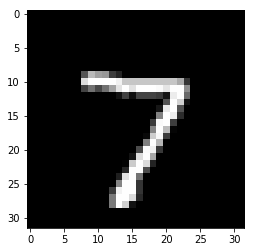

In [5]:
plt.imshow(test_images[0][0],cmap = 'gray')
plt.show()

In [6]:
def window_process2(samples, kernel_size, stride):
    n, c, h, w= samples.shape
    output_h = (h - kernel_size) // stride + 1
    output_w = (w - kernel_size) // stride + 1
    # samples2=np.moveaxis(samples, 3, 1)
    print('SAMPLES:',samples.shape)
    patches=saab.view_as_windows(samples, (1, c, kernel_size, kernel_size), step=(1, c, stride, stride))
    print('PATCHES1:',patches.shape)
    patches=patches.reshape(n,output_h, output_w, c*kernel_size*kernel_size)
    print('PATCHES2:',patches.shape)
    return patches

def initialize(sample_images, pca_params, pre_stage=0,stride=4):
    num_layers = pca_params['num_layers']-pre_stage
    kernel_sizes = pca_params['kernel_size']

    for i in range(num_layers):
        print('--------stage %d --------' % i)
        # Extract parameters
        feature_expectation = pca_params['Layer_%d/feature_expectation' % i].astype(np.float32)
        kernels = pca_params['Layer_%d/kernel' % i].astype(np.float32)
        # mean = pca_params['Layer_%d/pca_mean' % i].astype(np.float32)
        print ('sample images shape: {}'.format(sample_images.shape))
        # Create patches
        # print 'sample_images {}: {}', sample_images.shape, sample_images[-2:]
        if i==0:
            sample_patches = window_process2(sample_images, kernel_sizes[i], stride)  # overlapping
            print ('sample_patches1: {}'.format(sample_patches.shape))

        elif i==1:
            sample_patches=window_process2(sample_images, kernel_sizes[i], stride)
            print ('sample_patches1: {}'.format(sample_patches.shape))
        elif i==2:
            sample_patches=window_process2(sample_images, kernel_sizes[i], stride)
            print ('sample_patches1: {}'.format(sample_patches.shape))

        h = sample_patches.shape[1]
        w = sample_patches.shape[2]
        # Flatten
        # (n*output_h*output_w, c*kernel_size*kernel_size)
        sample_patches = sample_patches.reshape([-1, sample_patches.shape[-1]])
        print ('sample_patches2: {}'.format(sample_patches.shape))
        # Remove feature mean (Set E(X)=0 for each dimension)
        # feature after removing mean, mean
        # sample_patches_centered, feature_expectation = remove_mean(sample_patches, axis=0)
        sample_patches_centered = sample_patches - feature_expectation
        # sample_patches_centered = sample_patches
        if i == 0:
            
            transformed = np.matmul(sample_patches_centered, np.transpose(kernels))
            
        else:
           
            bias = pca_params['Layer_%d/bias' % i].astype(np.float32)
            # Add bias
            # print 'num_channels: {}'.format(num_channels)
            sample_patches_centered_w_bias = sample_patches_centered + 1 / np.sqrt(150) * bias
            # bias1_tmp=np.zeros(150)+1/np.sqrt(num_channels)* bias
            # print 'conv2 bias1: ', np.matmul(bias1_tmp, weight)
            # Transform to get data for the next stage
            transformed = np.matmul(sample_patches_centered_w_bias, np.transpose(kernels))
            # Remove bias
            e = np.zeros((1, kernels.shape[0]),dtype=np.float32)
            e[0, 0] = 1
            transformed -= bias * e
            #print ('conv2 bias2: ', -bias*e)
            # print 'bias: {}'.format(bias)
            # temp=transformed.reshape(10000, 10, 10, 16)
            # temp=np.moveaxis(temp, 3, 1)
            # print 'conv2_2 shape {}, output: {}'.format(temp[:1].shape, temp[:1])

        # Reshape: place back as a 4-D feature map
        num_samples = sample_images.shape[0]
        sample_images = transformed.reshape(num_samples, h, w, -1)
        print('sample_images before move axis',sample_images.shape)
        sample_images=np.moveaxis(sample_images, 3, 1)
        # sample_images = transformed.reshape(num_samples, -1, h, w)
        # print 'sample_images1.shape: {}'.format(sample_images.shape)
        print('Sample patches shape after flatten:', sample_patches.shape)
        print('Kernel shape:', kernels.shape)
        print('Transformed shape:', transformed.shape)
        print('Sample images shape:', sample_images.shape)
    return sample_images

In [7]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

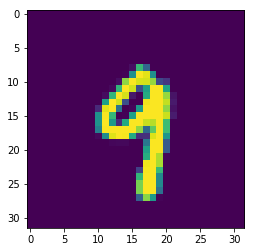

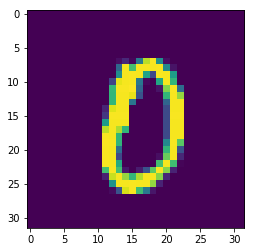

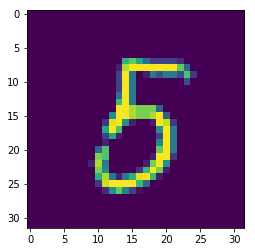

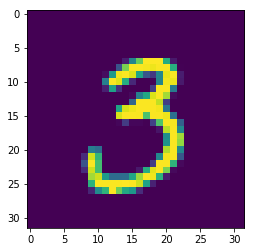

In [8]:
from PIL import Image
testimages=np.zeros((4,1,32,32),dtype=np.float32)
img = Image.open("C:/Users/Masoud/Desktop/HW6/1.png")
img = np.asarray(img)/np.max(img)
plt.imshow(img)
plt.show()
testimages[0]=img
img = Image.open("C:/Users/Masoud/Desktop/HW6/2.png")
img = np.asarray(img)/np.max(img)
plt.imshow(img)
plt.show()
testimages[1]=img
img = Image.open("C:/Users/Masoud/Desktop/HW6/3.png")
img = np.asarray(img)/np.max(img)
plt.imshow(img)
plt.show()
testimages[2]=img
img = Image.open("C:/Users/Masoud/Desktop/HW6/4.png")
img = np.asarray(img)/np.max(img)
plt.imshow(img)
plt.show()
testimages[3]=img

In [42]:
pca_params = KF.kernal(train_images, train_labels, test_images, test_labels, class_list,num_kernels="10,100", kernel_sizes="4,4")

Training image size: (60000, 1, 32, 32)
Testing_image size: (10000, 1, 32, 32)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [4, 4]
Number_kernels: [10, 100]
Energy_percent: None
Number_use_images: -1
Stride: 4
--------stage 0 --------
training_data.shape: (3840000, 16)
Num of kernels: 10
Energy percent: 0.968246
kernel: (11, 16)
Sample patches shape after flatten: (3840000, 16)
Kernel shape: (11, 16)
Transformed shape: (3840000, 11)
Sample images shape: (60000, 11, 4, 4)
--------stage 1 --------
training_data.shape: (60000, 176)
Num of kernels: 100
Energy percent: 0.991477
kernel: (101, 176)
Sample patches shape after flatten: (60000, 176)
Kernel shape: (101, 176)
Transformed shape: (60000, 101)
Sample images shape: (60000, 101, 1, 1)


In [81]:
out=initialize(testimages, pca_params,pre_stage=0)

--------stage 0 --------
sample images shape: (4, 1, 32, 32)
SAMPLES: (4, 1, 32, 32)
PATCHES1: (4, 1, 8, 8, 1, 1, 4, 4)
PATCHES2: (4, 8, 8, 16)
sample_patches1: (4, 8, 8, 16)
sample_patches2: (256, 16)
sample_images before move axis (4, 8, 8, 11)
Sample patches shape after flatten: (256, 16)
Kernel shape: (11, 16)
Transformed shape: (256, 11)
Sample images shape: (4, 11, 8, 8)
--------stage 1 --------
sample images shape: (4, 11, 8, 8)
SAMPLES: (4, 11, 8, 8)
PATCHES1: (4, 1, 2, 2, 1, 11, 4, 4)
PATCHES2: (4, 2, 2, 176)
sample_patches1: (4, 2, 2, 176)
sample_patches2: (16, 176)
sample_images before move axis (4, 2, 2, 101)
Sample patches shape after flatten: (16, 176)
Kernel shape: (101, 176)
Transformed shape: (16, 101)
Sample images shape: (4, 101, 2, 2)


C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


(101, 176)
(1, 176)
8.445638
(101, 2, 2)
(2, 2, 101)
(4, 101)
(1, 101)
(4, 101)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


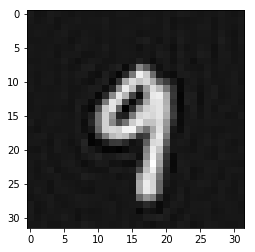

(101, 2, 2)
(2, 2, 101)
(4, 101)
(1, 101)
(4, 101)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


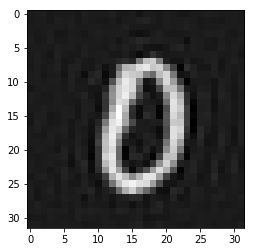

(101, 2, 2)
(2, 2, 101)
(4, 101)
(1, 101)
(4, 101)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


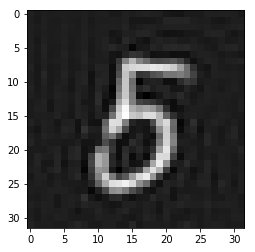

(101, 2, 2)
(2, 2, 101)
(4, 101)
(1, 101)
(4, 101)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


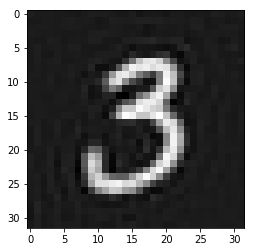

In [82]:
feature_expectation1 = pca_params['Layer_%d/feature_expectation' % 1].astype(np.float32)
kernels1 = pca_params['Layer_%d/kernel' % 1].astype(np.float32)
feature_expectation0 = pca_params['Layer_%d/feature_expectation' % 0].astype(np.float32)
kernels0 = pca_params['Layer_%d/kernel' % 0].astype(np.float32)
bias1 = pca_params['Layer_%d/bias' % 1].astype(np.float32)
print(kernels1.shape)
print(feature_expectation1.shape)
print(bias1)

finalimg=np.zeros((4,1,32,32),dtype=np.float32)

for num in range(4):
    outimg=out[num]
    print(outimg.shape)
    mid=np.moveaxis(outimg, 0, 2)
    print(mid.shape)
    mid = mid.reshape(4, -1)
    print(mid.shape)
    e = np.zeros((1,101),dtype=np.float32)
    print(e.shape)
    e[0, 0] = 1
    mid += bias1 * e
    print(mid.shape)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels1)))
    print(mid.shape)
    mid = mid - 1 / np.sqrt(150) * bias1
    mid = mid + feature_expectation1
    mid = mid.reshape(2,2,176)
    mid = mid.reshape(2, 2, 11, 4, 4)
    a=np.zeros((11,8,8),dtype=np.float32)
    for j in range(2):
        for i in range(2):    
            a[0:11,i*4:i*4+4,j*4:j*4+4] = mid[i,j]

    mid=a
    mid=np.moveaxis(mid, 1,2)
    mid=np.moveaxis(mid, 0, 2)
    print(mid.shape)
    mid=mid.reshape(64,11)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels0)))
    mid = mid + feature_expectation0
    print(mid.shape)
    mid=mid.reshape(64,4,4)
    print(mid.shape)
    #mid=mid.reshape(8,8,16)
    #print(mid.shape)
    a = np.zeros((1,32,32),dtype=np.float32)
    for j in range(8):
        for i in range(8):    
            a[0,i*4:i*4+4,j*4:j*4+4] = mid[i+8*j]
    mid=a
    #mid=np.moveaxis(mid, 1,2)
    finalimg[num]=mid;
    plt.imshow(mid[0],cmap = 'gray')
    plt.show()

In [83]:
print(psnr(finalimg[0][0],testimages[0][0]))
print(psnr(finalimg[1][0],testimages[1][0]))
print(psnr(finalimg[2][0],testimages[2][0]))
print(psnr(finalimg[3][0],testimages[3][0]))

28.236702338142084
25.63842824355802
25.597156086834914
27.19205490095712


In [84]:
pca_params = KF.kernal(train_images, train_labels, test_images, test_labels, class_list,num_kernels="10,140", kernel_sizes="4,4")

Training image size: (60000, 1, 32, 32)
Testing_image size: (10000, 1, 32, 32)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [4, 4]
Number_kernels: [10, 140]
Energy_percent: None
Number_use_images: -1
Stride: 4
--------stage 0 --------
training_data.shape: (3840000, 16)
Num of kernels: 10
Energy percent: 0.968246
kernel: (11, 16)
Sample patches shape after flatten: (3840000, 16)
Kernel shape: (11, 16)
Transformed shape: (3840000, 11)
Sample images shape: (60000, 11, 8, 8)
--------stage 1 --------


C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


training_data.shape: (240000, 176)
Num of kernels: 140
Energy percent: 0.993372
kernel: (141, 176)
Sample patches shape after flatten: (240000, 176)
Kernel shape: (141, 176)
Transformed shape: (240000, 141)
Sample images shape: (60000, 141, 2, 2)


In [85]:
out=initialize(testimages, pca_params,pre_stage=0)

--------stage 0 --------
sample images shape: (4, 1, 32, 32)
SAMPLES: (4, 1, 32, 32)
PATCHES1: (4, 1, 8, 8, 1, 1, 4, 4)
PATCHES2: (4, 8, 8, 16)
sample_patches1: (4, 8, 8, 16)
sample_patches2: (256, 16)
sample_images before move axis (4, 8, 8, 11)
Sample patches shape after flatten: (256, 16)
Kernel shape: (11, 16)
Transformed shape: (256, 11)
Sample images shape: (4, 11, 8, 8)
--------stage 1 --------
sample images shape: (4, 11, 8, 8)
SAMPLES: (4, 11, 8, 8)
PATCHES1: (4, 1, 2, 2, 1, 11, 4, 4)
PATCHES2: (4, 2, 2, 176)
sample_patches1: (4, 2, 2, 176)
sample_patches2: (16, 176)
sample_images before move axis (4, 2, 2, 141)
Sample patches shape after flatten: (16, 176)
Kernel shape: (141, 176)
Transformed shape: (16, 141)
Sample images shape: (4, 141, 2, 2)


C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


(141, 176)
(1, 176)
8.445638
(141, 2, 2)
(2, 2, 141)
(4, 141)
(1, 141)
(4, 141)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


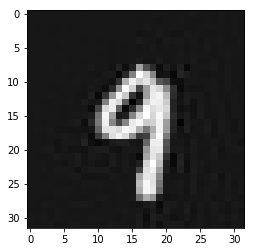

(141, 2, 2)
(2, 2, 141)
(4, 141)
(1, 141)
(4, 141)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


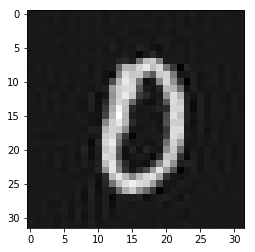

(141, 2, 2)
(2, 2, 141)
(4, 141)
(1, 141)
(4, 141)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


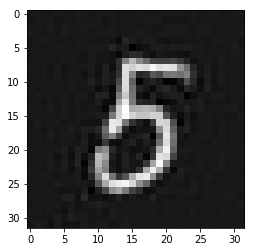

(141, 2, 2)
(2, 2, 141)
(4, 141)
(1, 141)
(4, 141)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


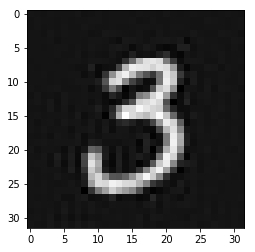

In [86]:
feature_expectation1 = pca_params['Layer_%d/feature_expectation' % 1].astype(np.float32)
kernels1 = pca_params['Layer_%d/kernel' % 1].astype(np.float32)
feature_expectation0 = pca_params['Layer_%d/feature_expectation' % 0].astype(np.float32)
kernels0 = pca_params['Layer_%d/kernel' % 0].astype(np.float32)
bias1 = pca_params['Layer_%d/bias' % 1].astype(np.float32)
print(kernels1.shape)
print(feature_expectation1.shape)
print(bias1)

finalimg=np.zeros((4,1,32,32),dtype=np.float32)

for num in range(4):
    outimg=out[num]
    print(outimg.shape)
    mid=np.moveaxis(outimg, 0, 2)
    print(mid.shape)
    mid = mid.reshape(4, -1)
    print(mid.shape)
    e = np.zeros((1,141),dtype=np.float32)
    print(e.shape)
    e[0, 0] = 1
    mid += bias1 * e
    print(mid.shape)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels1)))
    print(mid.shape)
    mid = mid - 1 / np.sqrt(150) * bias1
    mid = mid + feature_expectation1
    mid = mid.reshape(2,2,176)
    mid = mid.reshape(2, 2, 11, 4, 4)
    a=np.zeros((11,8,8),dtype=np.float32)
    for j in range(2):
        for i in range(2):    
            a[0:11,i*4:i*4+4,j*4:j*4+4] = mid[i,j]

    mid=a
    mid=np.moveaxis(mid, 1,2)
    mid=np.moveaxis(mid, 0, 2)
    print(mid.shape)
    mid=mid.reshape(64,11)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels0)))
    mid = mid + feature_expectation0
    print(mid.shape)
    mid=mid.reshape(64,4,4)
    print(mid.shape)
    #mid=mid.reshape(8,8,16)
    #print(mid.shape)
    a = np.zeros((1,32,32),dtype=np.float32)
    for j in range(8):
        for i in range(8):    
            a[0,i*4:i*4+4,j*4:j*4+4] = mid[i+8*j]
    mid=a
    finalimg[num]=mid;
    #mid=np.moveaxis(mid, 1,2)
    plt.imshow(mid[0],cmap = 'gray')
    plt.show()

In [87]:
print(psnr(finalimg[0][0],testimages[0][0]))
print(psnr(finalimg[1][0],testimages[1][0]))
print(psnr(finalimg[2][0],testimages[2][0]))
print(psnr(finalimg[3][0],testimages[3][0]))

31.550833740325732
28.434969744931745
28.313868574091373
28.80285980306639


Training image size: (60000, 1, 32, 32)
Testing_image size: (10000, 1, 32, 32)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [4, 4]
Number_kernels: [10, 60]
Energy_percent: None
Number_use_images: -1
Stride: 4
--------stage 0 --------
training_data.shape: (3840000, 16)
Num of kernels: 10
Energy percent: 0.968246
kernel: (11, 16)
Sample patches shape after flatten: (3840000, 16)
Kernel shape: (11, 16)
Transformed shape: (3840000, 11)
Sample images shape: (60000, 11, 8, 8)
--------stage 1 --------


C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


training_data.shape: (240000, 176)
Num of kernels: 60
Energy percent: 0.938710
kernel: (61, 176)
Sample patches shape after flatten: (240000, 176)
Kernel shape: (61, 176)
Transformed shape: (240000, 61)
Sample images shape: (60000, 61, 2, 2)
--------stage 0 --------
sample images shape: (4, 1, 32, 32)
SAMPLES: (4, 1, 32, 32)
PATCHES1: (4, 1, 8, 8, 1, 1, 4, 4)
PATCHES2: (4, 8, 8, 16)
sample_patches1: (4, 8, 8, 16)
sample_patches2: (256, 16)
sample_images before move axis (4, 8, 8, 11)
Sample patches shape after flatten: (256, 16)
Kernel shape: (11, 16)
Transformed shape: (256, 11)
Sample images shape: (4, 11, 8, 8)
--------stage 1 --------
sample images shape: (4, 11, 8, 8)
SAMPLES: (4, 11, 8, 8)
PATCHES1: (4, 1, 2, 2, 1, 11, 4, 4)
PATCHES2: (4, 2, 2, 176)
sample_patches1: (4, 2, 2, 176)
sample_patches2: (16, 176)
sample_images before move axis (4, 2, 2, 61)
Sample patches shape after flatten: (16, 176)
Kernel shape: (61, 176)
Transformed shape: (16, 61)
Sample images shape: (4, 61, 2, 

C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


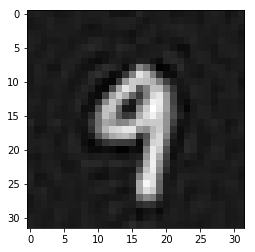

(61, 2, 2)
(2, 2, 61)
(4, 61)
(1, 61)
(4, 61)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


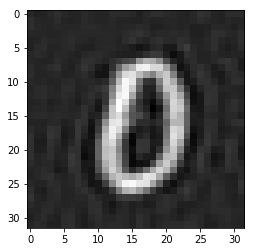

(61, 2, 2)
(2, 2, 61)
(4, 61)
(1, 61)
(4, 61)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


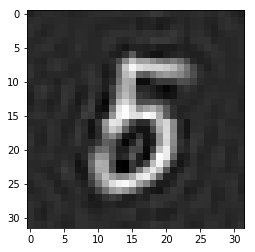

(61, 2, 2)
(2, 2, 61)
(4, 61)
(1, 61)
(4, 61)
(4, 176)
(8, 8, 11)
(64, 16)
(64, 4, 4)


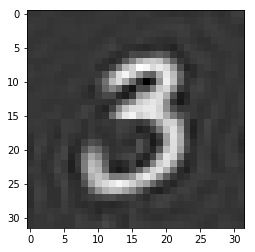

24.264718412507307
21.983540437510378
21.797403497309645
23.376597970359786


In [89]:
pca_params = KF.kernal(train_images, train_labels, test_images, test_labels, class_list,num_kernels="10,60", kernel_sizes="4,4")
out=initialize(testimages, pca_params,pre_stage=0)
feature_expectation1 = pca_params['Layer_%d/feature_expectation' % 1].astype(np.float32)
kernels1 = pca_params['Layer_%d/kernel' % 1].astype(np.float32)
feature_expectation0 = pca_params['Layer_%d/feature_expectation' % 0].astype(np.float32)
kernels0 = pca_params['Layer_%d/kernel' % 0].astype(np.float32)
bias1 = pca_params['Layer_%d/bias' % 1].astype(np.float32)
print(kernels1.shape)
print(feature_expectation1.shape)
print(bias1)

finalimg=np.zeros((4,1,32,32),dtype=np.float32)

for num in range(4):
    outimg=out[num]
    print(outimg.shape)
    mid=np.moveaxis(outimg, 0, 2)
    print(mid.shape)
    mid = mid.reshape(4, -1)
    print(mid.shape)
    e = np.zeros((1,61),dtype=np.float32)
    print(e.shape)
    e[0, 0] = 1
    mid += bias1 * e
    print(mid.shape)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels1)))
    print(mid.shape)
    mid = mid - 1 / np.sqrt(150) * bias1
    mid = mid + feature_expectation1
    mid = mid.reshape(2,2,176)
    mid = mid.reshape(2, 2, 11, 4, 4)
    a=np.zeros((11,8,8),dtype=np.float32)
    for j in range(2):
        for i in range(2):    
            a[0:11,i*4:i*4+4,j*4:j*4+4] = mid[i,j]

    mid=a
    mid=np.moveaxis(mid, 1,2)
    mid=np.moveaxis(mid, 0, 2)
    print(mid.shape)
    mid=mid.reshape(64,11)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels0)))
    mid = mid + feature_expectation0
    print(mid.shape)
    mid=mid.reshape(64,4,4)
    print(mid.shape)
    #mid=mid.reshape(8,8,16)
    #print(mid.shape)
    a = np.zeros((1,32,32),dtype=np.float32)
    for j in range(8):
        for i in range(8):    
            a[0,i*4:i*4+4,j*4:j*4+4] = mid[i+8*j]
    mid=a
    finalimg[num]=mid;
    #mid=np.moveaxis(mid, 1,2)
    plt.imshow(mid[0],cmap = 'gray')
    plt.show()
print(psnr(finalimg[0][0],testimages[0][0]))
print(psnr(finalimg[1][0],testimages[1][0]))
print(psnr(finalimg[2][0],testimages[2][0]))
print(psnr(finalimg[3][0],testimages[3][0]))

Training image size: (60000, 1, 32, 32)
Testing_image size: (10000, 1, 32, 32)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [4, 4]
Number_kernels: [12, 150]
Energy_percent: None
Number_use_images: -1
Stride: 4
--------stage 0 --------
training_data.shape: (3840000, 16)
Num of kernels: 12
Energy percent: 0.986070
kernel: (13, 16)
Sample patches shape after flatten: (3840000, 16)
Kernel shape: (13, 16)
Transformed shape: (3840000, 13)
Sample images shape: (60000, 13, 8, 8)
--------stage 1 --------


C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


training_data.shape: (240000, 208)
Num of kernels: 150
Energy percent: 0.990479
kernel: (151, 208)
Sample patches shape after flatten: (240000, 208)
Kernel shape: (151, 208)
Transformed shape: (240000, 151)
Sample images shape: (60000, 151, 2, 2)
--------stage 0 --------
sample images shape: (4, 1, 32, 32)
SAMPLES: (4, 1, 32, 32)
PATCHES1: (4, 1, 8, 8, 1, 1, 4, 4)
PATCHES2: (4, 8, 8, 16)
sample_patches1: (4, 8, 8, 16)
sample_patches2: (256, 16)
sample_images before move axis (4, 8, 8, 13)
Sample patches shape after flatten: (256, 16)
Kernel shape: (13, 16)
Transformed shape: (256, 13)
Sample images shape: (4, 13, 8, 8)
--------stage 1 --------
sample images shape: (4, 13, 8, 8)
SAMPLES: (4, 13, 8, 8)
PATCHES1: (4, 1, 2, 2, 1, 13, 4, 4)
PATCHES2: (4, 2, 2, 208)
sample_patches1: (4, 2, 2, 208)
sample_patches2: (16, 208)
sample_images before move axis (4, 2, 2, 151)
Sample patches shape after flatten: (16, 208)
Kernel shape: (151, 208)
Transformed shape: (16, 151)
Sample images shape: (4,

C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


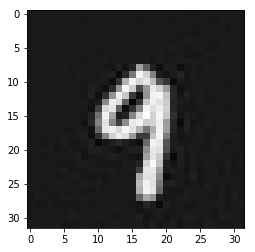

(151, 2, 2)
(2, 2, 151)
(4, 151)
(1, 151)
(4, 151)
(4, 208)
(8, 8, 13)
(64, 16)
(64, 4, 4)


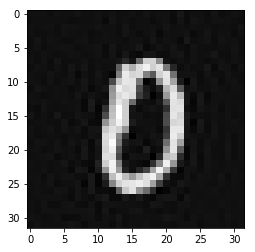

(151, 2, 2)
(2, 2, 151)
(4, 151)
(1, 151)
(4, 151)
(4, 208)
(8, 8, 13)
(64, 16)
(64, 4, 4)


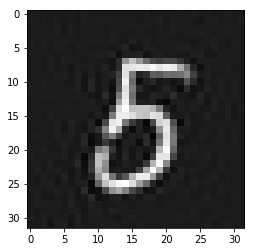

(151, 2, 2)
(2, 2, 151)
(4, 151)
(1, 151)
(4, 151)
(4, 208)
(8, 8, 13)
(64, 16)
(64, 4, 4)


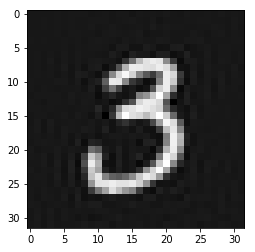

32.26341174279738
30.312671125580586
29.766849095496934
30.420549703261592


In [11]:
pca_params = KF.kernal(train_images, train_labels, test_images, test_labels, class_list,num_kernels="12,150", kernel_sizes="4,4",stride=4)
out=initialize(testimages, pca_params,pre_stage=0)
feature_expectation1 = pca_params['Layer_%d/feature_expectation' % 1].astype(np.float32)
kernels1 = pca_params['Layer_%d/kernel' % 1].astype(np.float32)
feature_expectation0 = pca_params['Layer_%d/feature_expectation' % 0].astype(np.float32)
kernels0 = pca_params['Layer_%d/kernel' % 0].astype(np.float32)
bias1 = pca_params['Layer_%d/bias' % 1].astype(np.float32)
print(kernels1.shape)
print(feature_expectation1.shape)
print(bias1)

finalimg=np.zeros((4,1,32,32),dtype=np.float32)

for num in range(4):
    outimg=out[num]
    print(outimg.shape)
    mid=np.moveaxis(outimg, 0, 2)
    print(mid.shape)
    mid = mid.reshape(4, -1)
    print(mid.shape)
    e = np.zeros((1,151),dtype=np.float32)
    print(e.shape)
    e[0, 0] = 1
    mid += bias1 * e
    print(mid.shape)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels1)))
    print(mid.shape)
    mid = mid - 1 / np.sqrt(150) * bias1
    mid = mid + feature_expectation1
    mid = mid.reshape(2,2,208)
    mid = mid.reshape(2, 2, 13, 4, 4)
    a=np.zeros((13,8,8),dtype=np.float32)
    for j in range(2):
        for i in range(2):    
            a[0:13,i*4:i*4+4,j*4:j*4+4] = mid[i,j]

    mid=a
    mid=np.moveaxis(mid, 1,2)
    mid=np.moveaxis(mid, 0, 2)
    print(mid.shape)
    mid=mid.reshape(64,13)
    mid = np.matmul(mid, np.linalg.pinv(np.transpose(kernels0)))
    mid = mid + feature_expectation0
    print(mid.shape)
    mid=mid.reshape(64,4,4)
    print(mid.shape)
    #mid=mid.reshape(8,8,16)
    #print(mid.shape)
    a = np.zeros((1,32,32),dtype=np.float32)
    for j in range(8):
        for i in range(8):    
            a[0,i*4:i*4+4,j*4:j*4+4] = mid[i+8*j]
    mid=a
    finalimg[num]=mid;
    #mid=np.moveaxis(mid, 1,2)
    plt.imshow(mid[0],cmap = 'gray')
    plt.show()
print(psnr(finalimg[0][0],testimages[0][0]))
print(psnr(finalimg[1][0],testimages[1][0]))
print(psnr(finalimg[2][0],testimages[2][0]))
print(psnr(finalimg[3][0],testimages[3][0]))

In [9]:
pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="5,5",stride=1)
#out=initialize(testimages, pca_params,pre_stage=0)
feature_expectation1 = pca_params['Layer_%d/feature_expectation' % 1].astype(np.float32)
kernels1 = pca_params['Layer_%d/kernel' % 1].astype(np.float32)
feature_expectation0 = pca_params['Layer_%d/feature_expectation' % 0].astype(np.float32)
kernels0 = pca_params['Layer_%d/kernel' % 0].astype(np.float32)
bias1 = pca_params['Layer_%d/bias' % 1].astype(np.float32)


Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 1, 32, 32)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [5, 5]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (14112000, 25)
Num of kernels: 5
Energy percent: 0.794629
kernel: (6, 25)
Sample patches shape after flatten: (14112000, 25)
Kernel shape: (6, 25)
Transformed shape: (14112000, 6)
Sample images shape: (18000, 6, 14, 14)
--------stage 1 --------
training_data.shape: (1800000, 150)
Num of kernels: 15
Energy percent: 0.865067
kernel: (16, 150)
Sample patches shape after flatten: (1800000, 150)
Kernel shape: (16, 150)
Transformed shape: (1800000, 16)
Sample images shape: (18000, 16, 5, 5)


In [43]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 28, 28, 25)
sample_patches2: (47040000, 25)
Sample patches shape after flatten: (47040000, 25)
Kernel shape: (6, 25)
Transformed shape: (47040000, 6)
Sample images shape: (60000, 6, 14, 14)
--------stage 1 --------
sample images shape: (60000, 6, 14, 14)
sample_patches1: (60000, 10, 10, 150)
sample_patches2: (6000000, 150)
Sample patches shape after flatten: (6000000, 150)
Kernel shape: (16, 150)
Transformed shape: (6000000, 16)
Sample images shape: (60000, 16, 5, 5)


In [44]:
feature.shape

(60000, 400)

In [45]:
feature=feature.reshape(60000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

In [46]:
num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
# save data
fw = open('llsr_weights_compact_v2.pkl', 'wb')
pickle.dump(weights, fw, protocol=2)
fw.close()
fw = open('llsr_bias_compact_v2.pkl', 'wb')
pickle.dump(bias, fw, protocol=2)

fw.close()

0  layer Kmean (just ref) training acc is 0.8731833333333333
weight 59999  dtype: float32 
weights save....
weights saved!
0  layer LSR weight shape: (401, 120)
0  layer LSR output shape: (60000, 120)
0  layer LSR training acc is 0.9549666666666666
1  layer Kmean (just ref) training acc is 0.94685
weight 59999  dtype: float32 
weights save....
weights saved!
1  layer LSR weight shape: (121, 84)
1  layer LSR output shape: (60000, 84)
1  layer LSR training acc is 0.9576666666666667
weight 59999  dtype: float32 
2  layer LSR weight shape: (85, 10)
2  layer LSR output shape: (60000, 10)
training acc is 0.9703833333333334


In [47]:
test_images=np.moveaxis(test_images, 3, 1)
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 28, 28, 25)
sample_patches2: (7840000, 25)
Sample patches shape after flatten: (7840000, 25)
Kernel shape: (6, 25)
Transformed shape: (7840000, 6)
Sample images shape: (10000, 6, 14, 14)
--------stage 1 --------
sample images shape: (10000, 6, 14, 14)
sample_patches1: (10000, 10, 10, 150)
sample_patches2: (1000000, 150)
Sample patches shape after flatten: (1000000, 150)
Kernel shape: (16, 150)
Transformed shape: (1000000, 16)
Sample images shape: (10000, 16, 5, 5)


In [50]:
print(weights['%d LLSR weight' % 1] .astype(np.float32).shape)
bias['%d LLSR bias' % 0] 
feature.shape

(120, 84)


(10000, 400)

In [52]:
l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

saved_testing_features[0]=l3out

(10000, 120)
(10000, 10)


In [58]:
test_labels[0]

7

In [59]:
currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

In [60]:
acc_train 

0.9638

In [9]:
saved_training_features=np.zeros((10,60000,10))
saved_testing_features=np.zeros((10,10000,10))


In [20]:
##PART 3
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="5,5",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[0]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [5, 5]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (14112000, 25)
Num of kernels: 5
Energy percent: 0.794629
kernel: (6, 25)
Sample patches shape after flatten: (14112000, 25)
Kernel shape: (6, 25)
Transformed shape: (14112000, 6)
Sample images shape: (18000, 6, 14, 14)
--------stage 1 --------
training_data.shape: (1800000, 150)
Num of kernels: 15
Energy percent: 0.865067
kernel: (16, 150)
Sample patches shape after flatten: (1800000, 150)
Kernel shape: (16, 150)
Transformed shape: (1800000, 16)
Sample images shape: (18000, 16, 5, 5)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 28, 28, 25)
sample_patches2: (47040000, 25)
Sample patches s

In [21]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[0]=l3out

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 28, 28, 25)
sample_patches2: (7840000, 25)
Sample patches shape after flatten: (7840000, 25)
Kernel shape: (6, 25)
Transformed shape: (7840000, 6)
Sample images shape: (10000, 6, 14, 14)
--------stage 1 --------
sample images shape: (10000, 6, 14, 14)
sample_patches1: (10000, 10, 10, 150)
sample_patches2: (1000000, 150)
Sample patches shape after flatten: (1000000, 150)
Kernel shape: (16, 150)
Transformed shape: (1000000, 16)
Sample images shape: (10000, 16, 5, 5)
(10000, 120)
(10000, 10)


In [22]:
acc_train


0.9631

In [25]:
##PART 3
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="5,3",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[1]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [5, 3]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (14112000, 25)
Num of kernels: 5
Energy percent: 0.794629
kernel: (6, 25)
Sample patches shape after flatten: (14112000, 25)
Kernel shape: (6, 25)
Transformed shape: (14112000, 6)
Sample images shape: (18000, 6, 14, 14)
--------stage 1 --------
training_data.shape: (2592000, 54)
Num of kernels: 15
Energy percent: 0.949191
kernel: (16, 54)
Sample patches shape after flatten: (2592000, 54)
Kernel shape: (16, 54)
Transformed shape: (2592000, 16)
Sample images shape: (18000, 16, 6, 6)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 28, 28, 25)
sample_patches2: (47040000, 25)
Sample patches shape

In [28]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16,6,6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)
currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[1]=l3out
acc_train

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 28, 28, 25)
sample_patches2: (7840000, 25)
Sample patches shape after flatten: (7840000, 25)
Kernel shape: (6, 25)
Transformed shape: (7840000, 6)
Sample images shape: (10000, 6, 14, 14)
--------stage 1 --------
sample images shape: (10000, 6, 14, 14)
sample_patches1: (10000, 12, 12, 54)
sample_patches2: (1440000, 54)
Sample patches shape after flatten: (1440000, 54)
Kernel shape: (16, 54)
Transformed shape: (1440000, 16)
Sample images shape: (10000, 16, 6, 6)
(10000, 120)
(10000, 10)


0.9672

In [30]:
##PART 3
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="3,5",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 6,6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[2]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [3, 5]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (16200000, 9)
Num of kernels: 5
Energy percent: 0.942017
kernel: (6, 9)
Sample patches shape after flatten: (16200000, 9)
Kernel shape: (6, 9)
Transformed shape: (16200000, 6)
Sample images shape: (18000, 6, 15, 15)
--------stage 1 --------
training_data.shape: (2178000, 150)
Num of kernels: 15
Energy percent: 0.885349
kernel: (16, 150)
Sample patches shape after flatten: (2178000, 150)
Kernel shape: (16, 150)
Transformed shape: (2178000, 16)
Sample images shape: (18000, 16, 6, 6)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 30, 30, 9)
sample_patches2: (54000000, 9)
Sample patches shape a

In [31]:
test_images=np.moveaxis(test_images, 3, 1)
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)
currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[2]=l3out
acc_train

--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 30, 30, 9)
sample_patches2: (9000000, 9)
Sample patches shape after flatten: (9000000, 9)
Kernel shape: (6, 9)
Transformed shape: (9000000, 6)
Sample images shape: (10000, 6, 15, 15)
--------stage 1 --------
sample images shape: (10000, 6, 15, 15)
sample_patches1: (10000, 11, 11, 150)
sample_patches2: (1210000, 150)
Sample patches shape after flatten: (1210000, 150)
Kernel shape: (16, 150)
Transformed shape: (1210000, 16)
Sample images shape: (10000, 16, 6, 6)
(10000, 120)
(10000, 10)


0.9671

In [33]:
##PART 3
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="3,3",stride=1)

train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 7, 7)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 7*7*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[3]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [3, 3]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (16200000, 9)
Num of kernels: 5
Energy percent: 0.942017
kernel: (6, 9)
Sample patches shape after flatten: (16200000, 9)
Kernel shape: (6, 9)
Transformed shape: (16200000, 6)
Sample images shape: (18000, 6, 15, 15)
--------stage 1 --------
training_data.shape: (3042000, 54)
Num of kernels: 15
Energy percent: 0.953959
kernel: (16, 54)
Sample patches shape after flatten: (3042000, 54)
Kernel shape: (16, 54)
Transformed shape: (3042000, 16)
Sample images shape: (18000, 16, 7, 7)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 30, 30, 9)
sample_patches2: (54000000, 9)
Sample patches shape after

In [34]:
test_images=np.moveaxis(test_images, 3, 1)
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 7, 7)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 7*7*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)
currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[3]=l3out
acc_train

--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 30, 30, 9)
sample_patches2: (9000000, 9)
Sample patches shape after flatten: (9000000, 9)
Kernel shape: (6, 9)
Transformed shape: (9000000, 6)
Sample images shape: (10000, 6, 15, 15)
--------stage 1 --------
sample images shape: (10000, 6, 15, 15)
sample_patches1: (10000, 13, 13, 54)
sample_patches2: (1690000, 54)
Sample patches shape after flatten: (1690000, 54)
Kernel shape: (16, 54)
Transformed shape: (1690000, 16)
Sample images shape: (10000, 16, 7, 7)
(10000, 120)
(10000, 10)


0.9637

In [55]:
filt=[[1 ,0 ,-1],[2 ,0 ,-2],[1,0,-1]]
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]

pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="5,5",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]
feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[4]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [5, 5]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (14112000, 25)
Num of kernels: 5
Energy percent: 0.846944
kernel: (6, 25)
Sample patches shape after flatten: (14112000, 25)
Kernel shape: (6, 25)
Transformed shape: (14112000, 6)
Sample images shape: (18000, 6, 14, 14)
--------stage 1 --------
training_data.shape: (1800000, 150)
Num of kernels: 15
Energy percent: 0.807870
kernel: (16, 150)
Sample patches shape after flatten: (1800000, 150)
Kernel shape: (16, 150)
Transformed shape: (1800000, 16)
Sample images shape: (18000, 16, 5, 5)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 28, 28, 25)
sample_patches2: (47040000, 25)
Sample patches s

In [56]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
for i in range(test_images.shape[0]):
    test_images[i][0]=signal.correlate2d(test_images[i][0],filt)[1:33,1:33]
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[4]=l3out

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 28, 28, 25)
sample_patches2: (7840000, 25)
Sample patches shape after flatten: (7840000, 25)
Kernel shape: (6, 25)
Transformed shape: (7840000, 6)
Sample images shape: (10000, 6, 14, 14)
--------stage 1 --------
sample images shape: (10000, 6, 14, 14)
sample_patches1: (10000, 10, 10, 150)
sample_patches2: (1000000, 150)
Sample patches shape after flatten: (1000000, 150)
Kernel shape: (16, 150)
Transformed shape: (1000000, 16)
Sample images shape: (10000, 16, 5, 5)
(10000, 120)
(10000, 10)


In [57]:
acc_train

0.9377

In [58]:
filt=[[1 ,0 ,-1],[2 ,0 ,-2],[1,0,-1]]
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]

pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="5,3",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)

for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]

feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[5]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [5, 3]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (14112000, 25)
Num of kernels: 5
Energy percent: 0.846944
kernel: (6, 25)
Sample patches shape after flatten: (14112000, 25)
Kernel shape: (6, 25)
Transformed shape: (14112000, 6)
Sample images shape: (18000, 6, 14, 14)
--------stage 1 --------
training_data.shape: (2592000, 54)
Num of kernels: 15
Energy percent: 0.910619
kernel: (16, 54)
Sample patches shape after flatten: (2592000, 54)
Kernel shape: (16, 54)
Transformed shape: (2592000, 16)
Sample images shape: (18000, 16, 6, 6)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 28, 28, 25)
sample_patches2: (47040000, 25)
Sample patches shape

In [59]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
for i in range(test_images.shape[0]):
    test_images[i][0]=signal.correlate2d(test_images[i][0],filt)[1:33,1:33]
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[5]=l3out

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 28, 28, 25)
sample_patches2: (7840000, 25)
Sample patches shape after flatten: (7840000, 25)
Kernel shape: (6, 25)
Transformed shape: (7840000, 6)
Sample images shape: (10000, 6, 14, 14)
--------stage 1 --------
sample images shape: (10000, 6, 14, 14)
sample_patches1: (10000, 12, 12, 54)
sample_patches2: (1440000, 54)
Sample patches shape after flatten: (1440000, 54)
Kernel shape: (16, 54)
Transformed shape: (1440000, 16)
Sample images shape: (10000, 16, 6, 6)
(10000, 120)
(10000, 10)


In [60]:
filt=[[1 ,0 ,-1],[2 ,0 ,-2],[1,0,-1]]
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]

pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="3,5",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)

for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]

feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[6]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [3, 5]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (16200000, 9)
Num of kernels: 5
Energy percent: 0.980326
kernel: (6, 9)
Sample patches shape after flatten: (16200000, 9)
Kernel shape: (6, 9)
Transformed shape: (16200000, 6)
Sample images shape: (18000, 6, 15, 15)
--------stage 1 --------
training_data.shape: (2178000, 150)
Num of kernels: 15
Energy percent: 0.805369
kernel: (16, 150)
Sample patches shape after flatten: (2178000, 150)
Kernel shape: (16, 150)
Transformed shape: (2178000, 16)
Sample images shape: (18000, 16, 6, 6)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 30, 30, 9)
sample_patches2: (54000000, 9)
Sample patches shape a

In [61]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
for i in range(test_images.shape[0]):
    test_images[i][0]=signal.correlate2d(test_images[i][0],filt)[1:33,1:33]
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[6]=l3out
acc_train

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 30, 30, 9)
sample_patches2: (9000000, 9)
Sample patches shape after flatten: (9000000, 9)
Kernel shape: (6, 9)
Transformed shape: (9000000, 6)
Sample images shape: (10000, 6, 15, 15)
--------stage 1 --------
sample images shape: (10000, 6, 15, 15)
sample_patches1: (10000, 11, 11, 150)
sample_patches2: (1210000, 150)
Sample patches shape after flatten: (1210000, 150)
Kernel shape: (16, 150)
Transformed shape: (1210000, 16)
Sample images shape: (10000, 16, 6, 6)
(10000, 120)
(10000, 10)


In [62]:
filt=[[1 ,0 ,-1],[2 ,0 ,-2],[1,0,-1]]
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]

pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="3,3",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)

for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],filt)[1:33,1:33]

feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 7, 7)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 7*7*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[7]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [3, 3]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (16200000, 9)
Num of kernels: 5
Energy percent: 0.980326
kernel: (6, 9)
Sample patches shape after flatten: (16200000, 9)
Kernel shape: (6, 9)
Transformed shape: (16200000, 6)
Sample images shape: (18000, 6, 15, 15)
--------stage 1 --------
training_data.shape: (3042000, 54)
Num of kernels: 15
Energy percent: 0.917840
kernel: (16, 54)
Sample patches shape after flatten: (3042000, 54)
Kernel shape: (16, 54)
Transformed shape: (3042000, 16)
Sample images shape: (18000, 16, 7, 7)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 30, 30, 9)
sample_patches2: (54000000, 9)
Sample patches shape after

In [63]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
for i in range(test_images.shape[0]):
    test_images[i][0]=signal.correlate2d(test_images[i][0],filt)[1:33,1:33]
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 7, 7)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 7*7*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[7]=l3out
acc_train

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 30, 30, 9)
sample_patches2: (9000000, 9)
Sample patches shape after flatten: (9000000, 9)
Kernel shape: (6, 9)
Transformed shape: (9000000, 6)
Sample images shape: (10000, 6, 15, 15)
--------stage 1 --------
sample images shape: (10000, 6, 15, 15)
sample_patches1: (10000, 13, 13, 54)
sample_patches2: (1690000, 54)
Sample patches shape after flatten: (1690000, 54)
Kernel shape: (16, 54)
Transformed shape: (1690000, 16)
Sample images shape: (10000, 16, 7, 7)
(10000, 120)
(10000, 10)


In [68]:
filt=[[1 ,0 ,-1],[2 ,0 ,-2],[1,0,-1]]
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],np.transpose(filt))[1:33,1:33]

pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="5,5",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)

for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],np.transpose(filt))[1:33,1:33]

feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[8]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [5, 5]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (14112000, 25)
Num of kernels: 5
Energy percent: 0.835480
kernel: (6, 25)
Sample patches shape after flatten: (14112000, 25)
Kernel shape: (6, 25)
Transformed shape: (14112000, 6)
Sample images shape: (18000, 6, 14, 14)
--------stage 1 --------
training_data.shape: (1800000, 150)
Num of kernels: 15
Energy percent: 0.785326
kernel: (16, 150)
Sample patches shape after flatten: (1800000, 150)
Kernel shape: (16, 150)
Transformed shape: (1800000, 16)
Sample images shape: (18000, 16, 5, 5)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 28, 28, 25)
sample_patches2: (47040000, 25)
Sample patches s

In [69]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
for i in range(test_images.shape[0]):
    test_images[i][0]=signal.correlate2d(test_images[i][0],np.transpose(filt))[1:33,1:33]
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 5, 5)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 5*5*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[8]=l3out
acc_train

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 28, 28, 25)
sample_patches2: (7840000, 25)
Sample patches shape after flatten: (7840000, 25)
Kernel shape: (6, 25)
Transformed shape: (7840000, 6)
Sample images shape: (10000, 6, 14, 14)
--------stage 1 --------
sample images shape: (10000, 6, 14, 14)
sample_patches1: (10000, 10, 10, 150)
sample_patches2: (1000000, 150)
Sample patches shape after flatten: (1000000, 150)
Kernel shape: (16, 150)
Transformed shape: (1000000, 16)
Sample images shape: (10000, 16, 5, 5)
(10000, 120)
(10000, 10)


0.9502

In [70]:
filt=[[1 ,0 ,-1],[2 ,0 ,-2],[1,0,-1]]
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)
for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],np.transpose(filt))[1:33,1:33]

pca_params = KF.kernal(train_images[0:18000], train_labels[0:18000], test_images, test_labels, class_list,num_kernels="5,15", kernel_sizes="5,3",stride=1)
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
train_images=np.moveaxis(train_images, 3, 1)

for i in range(train_images.shape[0]):
    train_images[i][0]=signal.correlate2d(train_images[i][0],np.transpose(filt))[1:33,1:33]

feature = saab.initialize(train_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)

feature=feature.reshape(60000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

num_clusters = [120, 84, 10]
use_classes = 10
weights = {}
bias = {}

for k in range(len(num_clusters)):
    if k != len(num_clusters) - 1:
        # Kmeans
        kmeans = KMeans(n_clusters=num_clusters[k]).fit(feature)
        pred_labels = kmeans.labels_
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer Kmean (just ref) training acc is {}'.format(acc_train))
        
        # Compute centroids
        clus_labels = np.argmax(num_clas, axis=1)
        centroid = np.zeros((num_clusters[k], feature.shape[1]), dtype=np.float32)
        for i in range(num_clusters[k]):
            t = 0
            for j in range(feature.shape[0]):
                if pred_labels[j] == i and clus_labels[i] == train_labels[j]:
                    if t == 0:
                        feature_test = feature[j].reshape(1, -1)
                    else:
                        feature_test = np.concatenate((feature_test, feature[j].reshape(1, -1)), axis=0)
                    t += 1
            centroid[i] = np.mean(feature_test, axis=0, keepdims=True)
        # Compute one hot vector
        t = 0
        labels = np.zeros((feature.shape[0], num_clusters[k]), dtype=np.float32)
        for i in range(feature.shape[0]):
            if clus_labels[pred_labels[i]] == train_labels[i]:
                labels[i, pred_labels[i]] = 1
            else:
                distance_assigned = euclidean_distances(feature[i].reshape(1, -1),
                                                        centroid[pred_labels[i]].reshape(1, -1))
                cluster_special = [j for j in range(num_clusters[k]) if clus_labels[j] == train_labels[i]]
                distance = np.zeros(len(cluster_special))
                for j in range(len(cluster_special)):
                    distance[j] = euclidean_distances(feature[i].reshape(1, -1),
                                                      centroid[cluster_special[j]].reshape(1, -1))
                labels[i, cluster_special[np.argmin(distance)]] = 1
        # least square regression
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels)
        feature = np.matmul(feature, weight)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        print ('weights save....')
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        print ('weights saved!')
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        num_clas = np.zeros((num_clusters[k], use_classes), dtype=np.float32)
        for i in range(num_clusters[k]):
            for t in range(use_classes):
                for j in range(feature.shape[0]):
                    if pred_labels[j] == i and train_labels[j] == t:
                        num_clas[i, t] += 1
        acc_train = np.sum(np.amax(num_clas, axis=1)) / feature.shape[0]
        print(k, ' layer LSR training acc is {}'.format(acc_train))
        # Relu
        for i in range(feature.shape[0]):
            for j in range(feature.shape[1]):
                if feature[i, j] < 0:
                    feature[i, j] = 0
    else:
        # least square regression
        labels = keras.utils.to_categorical(train_labels, 10)
        A = np.ones((feature.shape[0], 1), dtype=np.float32)
        feature = np.concatenate((A, feature), axis=1)
        weight = np.matmul(LA.pinv(feature), labels).astype(np.float32)
        print( 'weight {}  dtype: {} '.format(i, weight.dtype))
        feature = np.matmul(feature, weight)
        weights['%d LLSR weight' % k] = weight[1:weight.shape[0]]
        bias['%d LLSR bias' % k] = weight[0].reshape(1, -1)
        print(k, ' layer LSR weight shape:', weight.shape)
        print(k, ' layer LSR output shape:', feature.shape)
        pred_labels = np.argmax(feature, axis=1)
        acc_train = sklearn.metrics.accuracy_score(train_labels, pred_labels)
        print('training acc is {}'.format(acc_train))
        

saved_training_features[9]=feature

initiali dtype:  float32
Training image size: (18000, 1, 32, 32)
Testing_image size: (10000, 32, 32, 1)
Training images.dtype  float32
Parameters:
use_classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Kernel_sizes: [5, 3]
Number_kernels: [5, 15]
Energy_percent: None
Number_use_images: -1
Stride: 1
--------stage 0 --------
training_data.shape: (14112000, 25)
Num of kernels: 5
Energy percent: 0.835480
kernel: (6, 25)
Sample patches shape after flatten: (14112000, 25)
Kernel shape: (6, 25)
Transformed shape: (14112000, 6)
Sample images shape: (18000, 6, 14, 14)
--------stage 1 --------
training_data.shape: (2592000, 54)
Num of kernels: 15
Energy percent: 0.906869
kernel: (16, 54)
Sample patches shape after flatten: (2592000, 54)
Kernel shape: (16, 54)
Transformed shape: (2592000, 16)
Sample images shape: (18000, 16, 6, 6)
initiali dtype:  float32
--------stage 0 --------
sample images shape: (60000, 1, 32, 32)
sample_patches1: (60000, 28, 28, 25)
sample_patches2: (47040000, 25)
Sample patches shape

In [71]:
train_images, train_labels, test_images, test_labels, class_list=import_data('0-9')
test_images=np.moveaxis(test_images, 3, 1)
for i in range(test_images.shape[0]):
    test_images[i][0]=signal.correlate2d(test_images[i][0],np.transpose(filt))[1:33,1:33]
feature = saab.initialize(test_images, pca_params,stride=1)
feature = feature.reshape(feature.shape[0], -1)
feature=feature.reshape(10000, 16, 6, 6)
feature=np.moveaxis(feature, 1, 3)
feature=feature.reshape(-1, 6*6*16)

l1out = np.matmul(feature, weights['%d LLSR weight' % 0].astype(np.float32))+bias['%d LLSR bias' % 0]
print(l1out.shape)
l2out = np.matmul(l1out, weights['%d LLSR weight' % 1].astype(np.float32))+bias['%d LLSR bias' % 1]
l3out = np.matmul(l2out, weights['%d LLSR weight' % 2].astype(np.float32))+bias['%d LLSR bias' % 2]
print(l3out.shape)

currects=0;
for i in range(feature.shape[0]):
    for j in range(10):
        if np.argmax(l3out[i])==j and test_labels[i]== j:
            currects += 1
acc_train = currects / feature.shape[0]

saved_testing_features[9]=l3out
acc_train

initiali dtype:  float32
--------stage 0 --------
sample images shape: (10000, 1, 32, 32)
sample_patches1: (10000, 28, 28, 25)
sample_patches2: (7840000, 25)
Sample patches shape after flatten: (7840000, 25)
Kernel shape: (6, 25)
Transformed shape: (7840000, 6)
Sample images shape: (10000, 6, 14, 14)
--------stage 1 --------
sample images shape: (10000, 6, 14, 14)
sample_patches1: (10000, 12, 12, 54)
sample_patches2: (1440000, 54)
Sample patches shape after flatten: (1440000, 54)
Kernel shape: (16, 54)
Transformed shape: (1440000, 16)
Sample images shape: (10000, 16, 6, 6)
(10000, 120)
(10000, 10)


0.9556

In [72]:
fw = open('saved_training_features.pkl', 'wb')
pickle.dump(saved_training_features, fw)
fw.close()
fw = open('saved_testing_features.pkl', 'wb')
pickle.dump(saved_testing_features, fw)
fw.close()

In [22]:
fr = open('saved_training_features.pkl', 'rb')
saved_training_features = pickle.load(fr)
fr.close()

fr = open('saved_testing_features.pkl', 'rb')
saved_testing_features = pickle.load(fr)
fr.close()

In [23]:
saved_training_features=np.moveaxis(saved_training_features,0,2)
print(saved_training_features.shape)
saved_training_features=saved_training_features.reshape(60000,100)
pca = PCA(60, svd_solver='full')
saved_training_features=pca.fit_transform(saved_training_features)
print(saved_training_features.shape)

saved_testing_features=np.moveaxis(saved_testing_features,0,2)
print(saved_testing_features.shape)
saved_testing_features=saved_testing_features.reshape(10000,100)
kernels = pca.components_[:60, :]
saved_testing_features=np.matmul(saved_testing_features, np.transpose(kernels))
print(saved_testing_features.shape)

(60000, 10, 10)
(60000, 60)
(10000, 10, 10)
(10000, 60)


In [35]:
clf = svm.SVC(gamma='auto')

clf.fit(saved_training_features, train_labels)

train_result = clf.predict(saved_training_features)
currects=0;
FFtrainingfailedcases=np.zeros(60000)
for i in range(60000):
    for j in range(10):
        if train_result [i]==j and train_labels[i]== j:
            currects += 1
            FFtrainingfailedcases[i]=0
            break
        else:
            FFtrainingfailedcases[i]=1
acc_train = currects / 60000
print('Train precision: ', acc_train)

test_result = clf.predict(saved_testing_features)
currects=0;
FFtestingfailedcases=np.zeros(10000)
for i in range(10000):
    for j in range(10):
        if test_result [i]==j and test_labels[i]== j:
            currects += 1
            FFtestingfailedcases[i]=0
            break
        else:
            FFtestingfailedcases[i]=1
acc_train = currects / 10000
print('Test precision: ', acc_train)

Train precision:  0.9825
Test precision:  0.9832


In [25]:
from keras.utils import np_utils
from sklearn import svm
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Sequential
import time
def PreprocessDataset():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32')/255
    x_test = x_test.astype('float32')/255
    x_train = x_train.reshape(x_train.shape[0], 28,28,1)
    x_test = x_test.reshape(x_test.shape[0], 28,28,1)
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    return [x_train, x_test, y_train, y_test]
x_train, x_test, y_train, y_test = PreprocessDataset()
print(x_train.shape)
print(y_train[0])

(60000, 28, 28, 1)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [38]:
filter_size = 5
def LEModel():
    model = Sequential()
    
    model.add(Convolution2D(6, kernel_size=(filter_size, filter_size), activation='relu', kernel_initializer='glorot_uniform',input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(16, kernel_size=(filter_size, filter_size), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(120, activation='relu'))

    model.add(Dense(84, activation='relu'))

    model.add(Dense(10, activation='softmax'))
                    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='sgd' ,metrics=['accuracy'])
    return model
  
def TrainModel(data=None, epochs=15, batch=16):
    start_time = time.time()
    model = LEModel()
    x_train, x_test, y_train, y_test = data
    history = model.fit(x_train, y_train, nb_epoch=epochs, batch_size=batch,validation_data=(x_test, y_test), verbose=1)
    print("Training took {0} seconds.".format(time.time() - start_time))
    return model, history, model

In [39]:
trained_model, training_history, model = TrainModel(data=[x_train, x_test, y_train, y_test])

C:\Users\Masoud\Anaconda3\envs\UMC-python2\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 38s 628us/step - loss: 0.5923 - acc: 0.8046 - val_loss: 0.1285 - val_acc: 0.9585
Epoch 2/15
60000/60000 [==============================] - 34s 566us/step - loss: 0.1737 - acc: 0.9468 - val_loss: 0.0793 - val_acc: 0.9744
Epoch 3/15
60000/60000 [==============================] - 35s 583us/step - loss: 0.1336 - acc: 0.9581 - val_loss: 0.0555 - val_acc: 0.9819
Epoch 4/15
60000/60000 [==============================] - 39s 650us/step - loss: 0.1140 - acc: 0.9649 - val_loss: 0.0482 - val_acc: 0.9844
Epoch 5/15
60000/60000 [==============================] - 41s 677us/step - loss: 0.1019 - acc: 0.9679 - val_loss: 0.0421 - val_acc: 0.9869
Epoch 6/15
60000/60000 [==============================] - 41s 686us/step - loss: 0.0926 - acc: 0.9710 - val_loss: 0.0416 - val_acc: 0.9862
Epoch 7/15
60000/60000 [==============================] - 41s 679us/step - loss: 0.0864 - acc: 0.9723 - val_loss: 0.

In [47]:
train_result2 = model.predict_classes(x_train)
currects=0;
FFtrainingfailedcases2=np.zeros(60000)
for i in range(60000):
    for j in range(10):
        if train_result2[i]==j and y_train[i,j]== 1:
            currects += 1
            FFtrainingfailedcases2[i]=0
            break
        else:
            FFtrainingfailedcases2[i]=1
acc_train = currects / 60000
print('Train precision: ', acc_train)

test_result2 = model.predict_classes(x_test)
currects=0;
FFtestingfailedcases2=np.zeros(10000)
for i in range(10000):
    for j in range(10):
        if test_result2[i]==j and y_test[i,j]==1:
            currects += 1
            FFtestingfailedcases2[i]=0
            break
        else:
            FFtestingfailedcases2[i]=1
acc_train = currects / 10000

Train precision:  0.9912


In [48]:
print('Test precision: ', acc_train)

Test precision:  0.9902


In [52]:
commonerr=0
numerr=0
numerr2=0
for i in range(60000):
    if  FFtrainingfailedcases2[i]==1 and  FFtrainingfailedcases[i]==1:
        commonerr+=1
    if  FFtrainingfailedcases[i]==1:
        numerr+=1
    if  FFtrainingfailedcases2[i]==1:
        numerr2+=1
    
print(commonerr/numerr)
print(commonerr/numerr2)

0.31523809523809526
0.6268939393939394


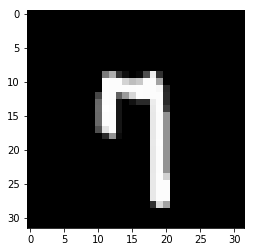

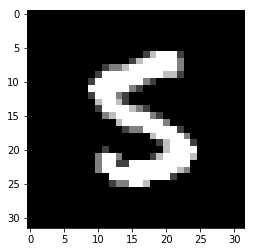

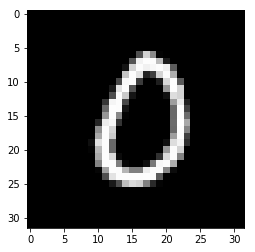

In [54]:
for i in range(400):
    if  FFtrainingfailedcases2[i]==1 and  FFtrainingfailedcases[i]==1:
        plt.imshow(test_images[i][0],cmap = 'gray')
        plt.show()